# Analysis of dynamical polarizability in the linear response formalism

We analyze the computation of the dynamical polarizabilityi inside the linear response formalism

In [96]:
%autosave 0
from BigDFT import Logfiles as lf
from BigDFT import Calculators as C
from futile import Yaml
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.insert(0,'../')
import Routine as R
outputpath = 'linear-response/'

Autosave disabled


First of all we compute the coupling matrix for various values of virtual orbitals

In [9]:
inp0 = {'dft' : 
        {'hgrids': 0.4,
         'gnrm_cv' : 1e-8,
         'itermax' : 100,
         'inputpsiid': 2},
        'tddft':{'tddft_approach': 'full'},
        'posinp': 'N2_posinp.xyz'}
Yaml.dump(inp0,outputpath + 'default.yaml')

In [10]:
numVirt=[16,32,64,128,256]

In [11]:
inp={'dft':
     {'rmult': [7.0, 9.0],
      'itermax_virt' : 1},
     'output': {
      'orbitals' : 'No'}, 
     'radical': 'Rmult_7.0'}
for n in numVirt:
    inp['dft']['norbv'] = -n
    inpname = 'NumVirt_'+str(n)
    Yaml.dump(inp,outputpath + inpname + '.yaml')

Execute one input file per time and copy by hand the coupling matrix and transition dipoles in the "TDDFT-Results" folder with the name coupling_matrix_n and transition_dipoles_n

In [12]:
code=C.SystemCalculator(omp=1,mpi=2)
%cd $outputpath
code.run(name='NumVirt_16',skip=True,outdir='./log/')
%cd ../

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/linear-response
Executing command:  OMP_NUM_THREADS=1 mpirun -np 2 $BIGDFT_ROOT/bigdft -n NumVirt_16 -d ./log/ -s Yes
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2


Read the data:

In [13]:
Data = []
%cd $outputpath
spath = 'log/'+str('log-NumVirt_')+str('*') 
logs = !ls $spath
print logs
for l in logs:
    Data.append(lf.Logfile(l))
# sort the Data list in the right order, with respect to the number of virtual orbitals
listnorbs=[len(l.evals[0][0]) for l in Data]
ipiv=np.argsort(listnorbs)
Data=[Data[i] for i in ipiv]
%cd ..

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/linear-response
['log/log-NumVirt_128.yaml', 'log/log-NumVirt_16.yaml', 'log/log-NumVirt_256.yaml', 'log/log-NumVirt_32.yaml', 'log/log-NumVirt_64.yaml']
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2


Read the coupling matrix and dipoles for each value of the number of virtual orbitals

In [14]:
dipoles = []
C = []
%cd $outputpath
dpath = 'log/TDDFT-Results/transition_dipoles_*'
logs = !ls $dpath
print logs
for l in logs:
    dipoles.append(np.loadtxt(l))
listnorbs=[d.shape[0] for d in dipoles]
ipiv=np.argsort(listnorbs)
dipoles=[dipoles[i] for i in ipiv]

Cpath = 'log/TDDFT-Results/coupling_matrix_*'
logs = !ls $Cpath
print logs
for l in logs:
    C.append(np.loadtxt(l))
    
listnorbs=[c.shape[0] for c in C]
ipiv=np.argsort(listnorbs)
C=[C[i] for i in ipiv]
%cd ..

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/linear-response
['log/TDDFT-Results/transition_dipoles_128.txt', 'log/TDDFT-Results/transition_dipoles_16.txt', 'log/TDDFT-Results/transition_dipoles_256.txt', 'log/TDDFT-Results/transition_dipoles_32.txt', 'log/TDDFT-Results/transition_dipoles_64.txt']
['log/TDDFT-Results/coupling_matrix_128.txt', 'log/TDDFT-Results/coupling_matrix_16.txt', 'log/TDDFT-Results/coupling_matrix_256.txt', 'log/TDDFT-Results/coupling_matrix_32.txt', 'log/TDDFT-Results/coupling_matrix_64.txt']
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2


In [15]:
dipoles[0][:,0] # the x component
print dipoles[4].shape[0]
print C[4].shape

2560
(2560, 2560)


We observe that $C$ is a symmetric matrix

In [33]:
np.allclose(C[4],C[4].T,atol=1.e-12)

True

## Spectral representation of the polarizability

Let us discuss the main formula needed for the computation of the polarizability. We consider
a dipole perturbation on the system so that the perturbing potential can be written as:
$$
\phi_j(\omega) = r_j F(\omega)
$$
$r_j$ indicates the direction of the field while the function $F$ keeps into account the amplitude of the pertubation and its $\omega$ dependence, and includes also the type of time evolution protocol (e.g. adiabatic or sudden). The expression of the induced dipole can be expressed in the basis of transition, according to the formula:
$$
d_{i}(\omega) = ( d_{i} | R(\omega) | d_{j}) F(\omega)
$$
Using the Casida formalism we have:
$$
d_{i}(\omega) = 2 \sum_{E^2} \frac{[d_i|C_{E^2}][\tilde C_{E^2}|d_j]}{(\omega+ 2i\eta)^2-E^2} F(\omega)
$$
where $|C_{E^2}]$ and $[\tilde C_{E^2}|$ are the right and left eigenvectors of the Casida matrix while $|d_i]$ and
$[d_j|$ represent the column and row vectors of components:
$$
d_i^{p\alpha} = T^{1/2}_{p\alpha} \int dr r_i \psi_p(r)\psi_{\alpha}(r)
$$

### Analysis of the statical polarizability

First of all we use this formalism to compare the value of the static polarizability given by this approach to the "exact" result obtained by explicitly adding a constant perturbing electric field in a DFT computation.
To perform this comparison we consider, in the linear response framework, a field switched on with an adiabatic protocol and we compute the (time dependent) induced dipole a t=0 (in which the damping factor of the adiabatic protocol is equal to one). Using the FT we have that:
$$
d_i(t=0) = \int \frac{d\omega}{2\pi} d_i(\omega)
$$
The F function associated to the adiabatic protocol of a constant perturbation of module equal to 1 is given by
$$
F(\omega) = \frac{2\tilde\eta}{\omega^2+\tilde\eta^2} 
$$
where $\tilde\eta$ is the damping parameter of the adiabatic protocol. For $\tilde\eta \rightarrow 0$ we recognize that this expression is equal to $2\pi\delta(\omega)$. So we have:
$$
d_i(t=0) = - 2 \sum_{E^2} \frac{[d_i|C_{E^2}][\tilde C_{E^2}|d_j]}{E^2}
$$
and this result has to reproduce, apart from the sign, the value of the static polarizability computed via a DFT computation.

In [16]:
#np.dot(C_E2.T[eigenvalue index],dipoles[numVirt])

In [17]:
alphaX = []
alphaY = []
alphaZ = []
for nind,nval in enumerate(numVirt):
    E2,C_E2=np.linalg.eigh(C[nind])
    R.validate_eigensystem(C[nind],E2,C_E2)
    sumx = 0.0
    sumy = 0.0
    sumz = 0.0
    for i,e in enumerate(E2):
        a = np.dot(C_E2.T[i],dipoles[nind])
        sumx+=2.0*a[0]*a[0]/e
        sumy+=2.0*a[1]*a[1]/e
        sumz+=2.0*a[2]*a[2]/e
    alphaX.append(sumx)
    alphaY.append(sumy)
    alphaZ.append(sumz)
print alphaX
print alphaY
print alphaZ

Validation terminated
Validation terminated
Validation terminated
Validation terminated
Validation terminated
[7.3652949235158021, 9.6242684281771655, 9.9364596435103074, 10.674896451768692, 10.810435542168234]
[7.3652950885610453, 9.624268446200837, 9.9364604951900208, 10.674900405725804, 10.809683402363975]
[11.059355580932314, 13.34246728190128, 14.112372652233761, 15.130321005997805, 15.477065014764865]


We plot these values together with the reference results

In [27]:
alphaX_ref = 10.87
alphaZ_ref = 15.74

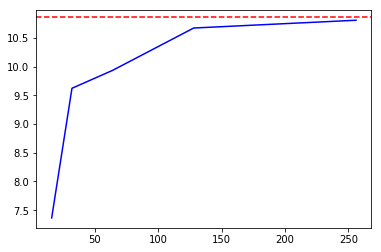

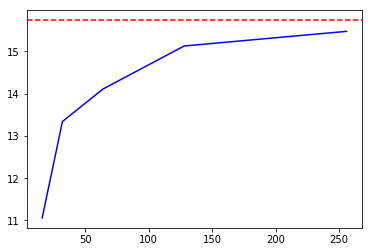

In [29]:
plt.plot(numVirt,alphaX,color ='b')
plt.axhline(y=alphaX_ref, color='r', linestyle='--')
plt.show()
plt.plot(numVirt,alphaZ,color='b')
plt.axhline(y=alphaZ_ref, color='r', linestyle='--')
plt.show()

### Dynamical polarizability in the adiabatic case

We compute the induced dipole in the adiabatic case. 
We consider a monocromatic perturbation of the form $H_1(t) = r_jcos(\omega_0 t)$. Using the formula for the
adiabatic case presented in the note, and remembering the representation of the delta function in terms of
a lorentzian we have that:
$$
F(\omega) = \frac{1}{2}\left(\delta(\omega-\omega_0) + \delta(\omega+\omega_0)\right)
$$
So, the induced dipole is nonvashing only for $\omega = \pm\omega_0$ and reads:
$$
d_{i}(\omega) = \sum_{E^2} \frac{[d_i|C_{E^2}][\tilde C_{E^2}|d_j]}{(\omega_0+ 2i\eta)^2-E^2} \delta(\omega-\omega_0)+
\sum_{E^2} \frac{[d_i|C_{E^2}][\tilde C_{E^2}|d_j]}{(\omega_0-2i\eta)^2-E^2} \delta(\omega+\omega_0)
$$

Now we want to plot $d_i$ in function of $\omega_0$, we consider only the first addend.
We consider the case with 256 empty orbitals and compute the highest eigenvalue of $C$. 
We choose $r_j = z$ and compute $d_z$

In [37]:
E2,C_E2=np.linalg.eigh(C[len(numVirt)-1])

The list E2 of the eigenvalues of $C$ is written in increasing order

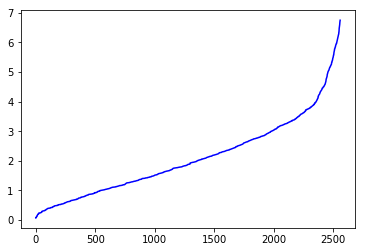

In [50]:
plt.plot(E2,color ='b')
plt.show()

with square root value of the highest eigenvalues

In [51]:
np.sqrt(E2[-1])

2.5974064619271817

In [103]:
numVal = 1000
omegaMax = 3.0
eta = 1.0e-2
deltaOmega = omegaMax/numVal
omega = [deltaOmega*i for i in range(numVal)]
# compute the factors of the numerator
A = []
for i in range(len(E2)):
    A.append(np.dot(C_E2.T[i],dipoles[len(numVirt)-1][:,2]))
# compute the induced dipole    
dz = []
for o in omega:
    s = 0.0
    for i,e in enumerate(E2):
        s+=A[i]**2/(complex(o,2*eta)**2-e)
    dz.append(s)

In [104]:
dz_r = []
dz_i = []
for x in dz:
    dz_r.append(-x.real)
    dz_i.append(-x.imag)

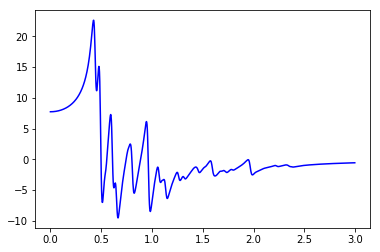

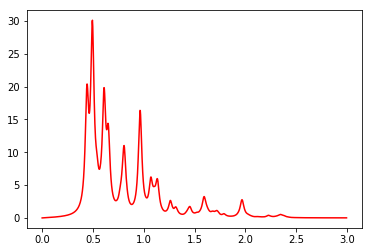

In [105]:
plt.plot(omega,dz_r,color ='b')
plt.show()
plt.plot(omega,dz_i,color ='r')
plt.show()